This demonstrates reconstruction of a Fresnel CDI dataset and compares the result to ePIE reconstruction. 

The probe structure allows reconstruction in CDI mode, i.e. without real-space overlap constraints. 

Scanning CDI reconstruction is also possible here, but results in a lower-quality image because of scan position jitter in this dataset.

In [1]:
from scipy.ndimage import zoom
import numpy as np

def init():
    from ptycho import params as p
    
    p.cfg['gridsize'] = 1
    p.cfg['nepochs'] = 50
    p.cfg['output_prefix'] = 'tmp'
    p.cfg['nimgs_train'] = 1
    p.cfg['nimgs_test'] = 1
    p.cfg['data_source'] = 'generic'
    p.cfg['intensity_scale.trainable'] = True
    p.cfg['positions.provided'] = True
    p.cfg['probe.big'] = True
    p.cfg['probe_scale'] = 5
    p.cfg['probe.mask'] = False
    p.cfg['train_data_file_path'] = 'train_data.npz'
    p.cfg['test_data_file_path'] = 'test_data.npz'
    

def probeshow(probeGuess):
    # Creating a figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Plotting the magnitude of the complex array
    img1 = ax1.imshow(np.abs(probeGuess), cmap='viridis')
    ax1.set_title('probe amplitude')
    fig.colorbar(img1, ax=ax1, orientation='vertical')

    # Plotting the phase of the complex array
    img2 = ax2.imshow(np.angle(probeGuess), cmap='jet')
    ax2.set_title('probe phase')
    fig.colorbar(img2, ax=ax2, orientation='vertical')

    # Plotting the scan point positions
    ax3.scatter(*(test_data['global_offsets'].squeeze().T))
    ax3.set_title('scan point positions')

    # Improving layout
    plt.tight_layout()
    plt.show()


def track_dict_changes(input_dict, callback):
    # Copy the original dictionary to track changes
    original_dict = input_dict.copy()
    # Execute the callback function
    callback(input_dict)
    # Determine which keys have changed or added
    changed_or_added_keys = [key for key in input_dict if input_dict.get(key) != original_dict.get(key)]
    return changed_or_added_keys

# IMPORTANT: must call init() BEFORE the dataset definition
init()

In [2]:
# !ln -s ../tests/test_generic_loader.py
import test_generic_loader
test_generic_loader.test_generic_loader(False)

2024-01-10 21:19:01.382464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-10 21:19:01.474495: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-10 21:19:01.904889: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/:/home/ollie/anaconda3/envs/tf/lib/
2024-01-10 21:19:01.904963: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin

raw diffraction shape (64, 64, 1087)
neighbor-sampled diffraction shape (1024, 64, 64, 1)
Train data written to train_data.npz
Train data written to test_data.npz


Structure of the preprocessed dataset:

In [3]:
from ptycho import probe
from scipy.ndimage import gaussian_filter as gf
from ptycho import params as p

from ptycho.xpp import *
probe_amp = np.absolute(probeGuess)
mask = np.absolute(p.get('probe_mask'))[:, :, 0, 0]
probe.set_probe_guess(None, probeGuess)

from ptycho.evaluation import save_metrics
from ptycho.evaluation import trim
from ptycho import tf_helper as hh

In [4]:
tf.random.set_seed(45)
from ptycho import params as p
from ptycho import train, model
from ptycho.train import *
from ptycho.nbutils import *

# channel dimensions size should be 1 in CDI mode, 4 in ptycho mode
test_data['X'].shape, train_data['X'].shape

neighbor-sampled diffraction shape (512, 64, 64, 1)
neighbor-sampled diffraction shape (1024, 64, 64, 1)
nphoton 8.998611747953772
1.3778547530504894
input shape (None, 64, 64, 1)
Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 64, 64, 1)    0           ['input[0][0]']                  
                                                                                                  
 conv2d (C

 conv2d_14 (Conv2D)             (None, 32, 32, 1)    1117        ['tf.__operators__.getitem_2[0][0
                                                                 ]']                              
                                                                                                  
 up_sampling2d_5 (UpSampling2D)  (None, 64, 64, 64)  0           ['conv2d_21[0][0]']              
                                                                                                  
 amp (Lambda)                   (None, 32, 32, 1)    0           ['conv2d_6[0][0]']               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 64, 64, 1)    577         ['up_sampling2d_2[0][0]']        
                                                                                                  
 phi (Lambda)                   (None, 32, 32, 1)    0           ['conv2d_14[0][0]']              
          

2024-01-10 21:19:09.030213: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2024-01-10 21:19:09.030230: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2024-01-10 21:19:09.030259: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2024-01-10 21:19:09.031379: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/:/home/ollie/anaconda3/envs/tf/lib/
2024-01-10 21:19:09.111755: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2024-01-10 21:19:09.112156: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


Epoch 1/50
input shape (None, 64, 64, 1)
input shape (None, 64, 64, 1)


2024-01-10 21:19:10.514682: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x79c1760
2024-01-10 21:19:11.513678: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


31/31 [==============================] - 5s 43ms/step - loss: 231306784.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 121.4558 - distribution_lambda_loss: 231306784.0000 - val_loss: 175974112.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 103.8478 - val_distribution_lambda_loss: 175974112.0000 - lr: 0.0010
Epoch 2/50
31/31 [==============================] - 0s 16ms/step - loss: 161854320.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 100.3864 - distribution_lambda_loss: 161854320.0000 - val_loss: 131225936.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 89.4821 - val_distribution_lambda_loss: 131225936.0000 - lr: 0.0010
Epoch 3/50
31/31 [==============================] - 0s 15ms/step - loss: 110846728.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 83.2218 - distribution_lambda_loss: 110846728.0000 - val_loss: 97137704.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 77.4604 - val_d

Epoch 24/50
31/31 [==============================] - 0s 15ms/step - loss: 19146052.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 36.9788 - distribution_lambda_loss: 19146052.0000 - val_loss: 20964170.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 38.6781 - val_distribution_lambda_loss: 20964170.0000 - lr: 0.0010
Epoch 25/50
31/31 [==============================] - 0s 15ms/step - loss: 18966726.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 36.7828 - distribution_lambda_loss: 18966726.0000 - val_loss: 18594606.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 36.3416 - val_distribution_lambda_loss: 18594606.0000 - lr: 0.0010
Epoch 26/50
31/31 [==============================] - 0s 15ms/step - loss: 18650560.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 36.5062 - distribution_lambda_loss: 18650560.0000 - val_loss: 18834600.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 36.3162 - val_

Epoch 46/50
31/31 [==============================] - 0s 15ms/step - loss: 11509800.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 28.9312 - distribution_lambda_loss: 11509800.0000 - val_loss: 12666244.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 30.1391 - val_distribution_lambda_loss: 12666244.0000 - lr: 2.5000e-04
Epoch 47/50
31/31 [==============================] - 0s 15ms/step - loss: 11412846.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 28.8089 - distribution_lambda_loss: 11412846.0000 - val_loss: 12603855.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 30.0664 - val_distribution_lambda_loss: 12603855.0000 - lr: 2.5000e-04
Epoch 48/50
31/31 [==============================] - 0s 15ms/step - loss: 11342741.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 28.7195 - distribution_lambda_loss: 11342741.0000 - val_loss: 12516564.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 29.946

(TensorShape([1024, 64, 64, 1]), TensorShape([512, 64, 64, 1]))

In [5]:
for key, value in test_data.items():
    if value is not None:
        if isinstance(value, tuple):
            print(f"{key}\t")
            for i, array in enumerate(value):
                print(f"  Array {i+1}{array.shape}, \t {array.dtype}")
        else:
            print(f"{key}\t{value.shape}, {value.dtype}")

X	(1024, 64, 64, 1), <dtype: 'float64'>
Y_I	(1024, 64, 64, 1), <dtype: 'float32'>
Y_phi	(1024, 64, 64, 1), <dtype: 'float32'>
norm_Y_I	(), <dtype: 'float64'>
coords	
  Array 1(1024, 1, 2, 1), 	 <dtype: 'float64'>
  Array 2(1024, 1, 2, 1), 	 <dtype: 'float64'>
nn_indices	(1024, 1), int64
global_offsets	(1024, 1, 2, 1), float64
local_offsets	(1024, 1, 2, 1), float64


In [7]:
%%time
obj_tensor_full, global_offsets = reconstruct_image(test_data)

32/32 [==============================] - 1s 22ms/step
CPU times: user 816 ms, sys: 70.7 ms, total: 886 ms
Wall time: 806 ms


In [8]:
recon_amp_ptychopinn = np.absolute(loader.reassemble_position(obj_tensor_full,
                                                  global_offsets[:, :, :, :],
                                              M = 20))

recon_phase_ptychopinn = np.angle(loader.reassemble_position(obj_tensor_full,
                                                  global_offsets[:, :, :, :],
                                              M = 20))

# ptycho_pinn_phase = (recon_phase_ptychopinn[..., 0])
# ptycho_pinn_amplitude = (recon_amp_ptychopinn[..., 0])
ptycho_pinn_phase = crop_to_non_uniform_region_with_buffer(recon_phase_ptychopinn[..., 0], buffer=23)
ptycho_pinn_amplitude = crop_to_non_uniform_region_with_buffer(recon_amp_ptychopinn[..., 0], buffer=23)

In [11]:
# %timeit -n 1 -r 1 model.diffraction_to_obj.predict(test_data['X'] * model.params()['intensity_scale'])

32/32 [==============================] - 0s 8ms/step
418 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Note the randomized scan point positions:

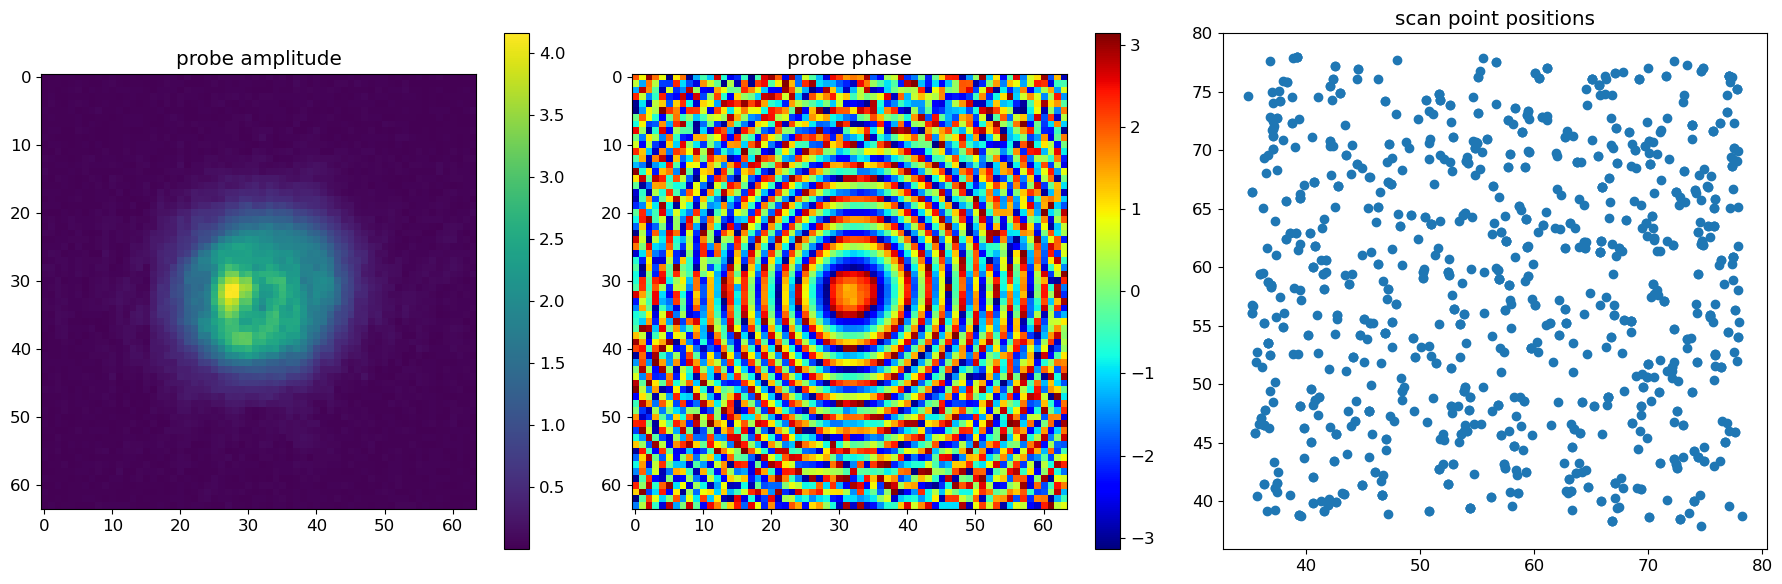

In [9]:
probeshow(probeGuess)

Now we reconstruct the full test object image and compare to the ePIE reconstruction:

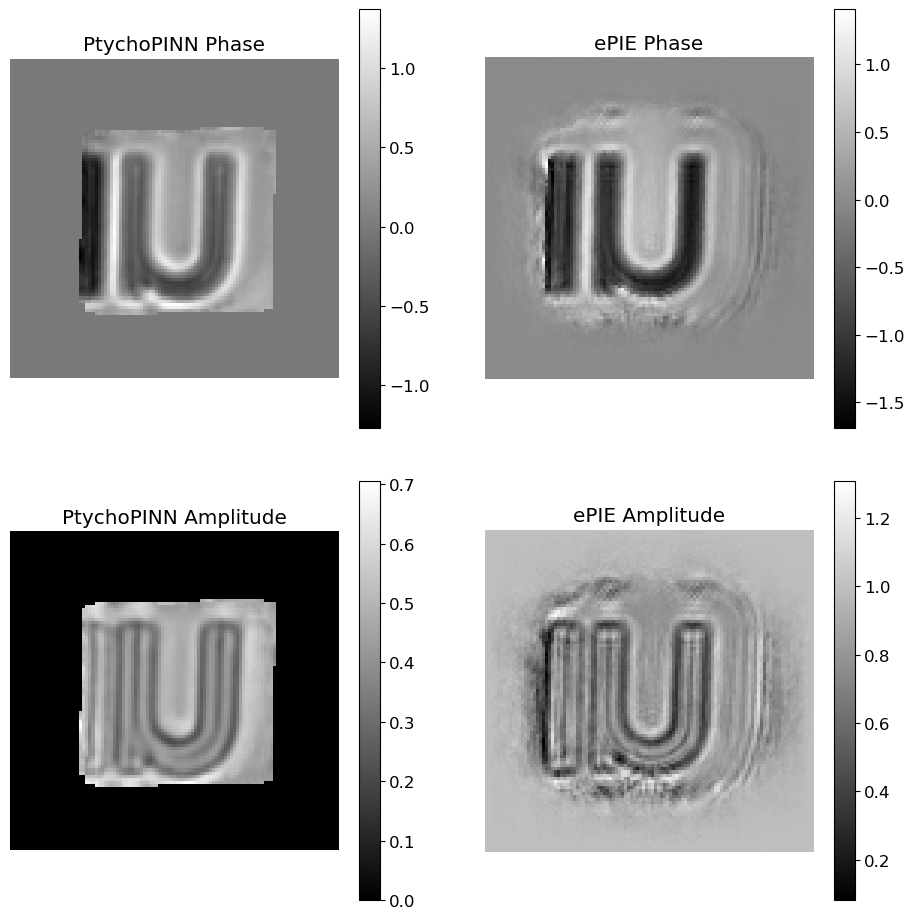

In [11]:
recon_amp = np.absolute(loader.reassemble_position(obj_tensor_full,
                                                  global_offsets[:, :, :, :],
                                              M = 20))

recon_phase = np.angle(loader.reassemble_position(obj_tensor_full,
                                                  global_offsets[:, :, :, :],
                                              M = 20))

epie_phase = crop_to_non_uniform_region_with_buffer(np.angle(obj['objectGuess']))
epie_amplitude = crop_to_non_uniform_region_with_buffer(np.absolute(obj['objectGuess']))

mk_epie_comparison2x2(ptycho_pinn_phase, epie_phase, ptycho_pinn_amplitude,epie_amplitude)

Reconstruction for a single solution region:

phase min: -3.0322459 phase max: 2.8536286


/home/ollie/anaconda3/envs/tf/lib/python3.9/site-packages/ptychoPINN-0.0.0-py3.9.egg/ptycho/evaluation.py:80: RuntimeWarning: divide by zero encountered in log
  true_diffraction = np.log(X_test)[i, :, :, channel]


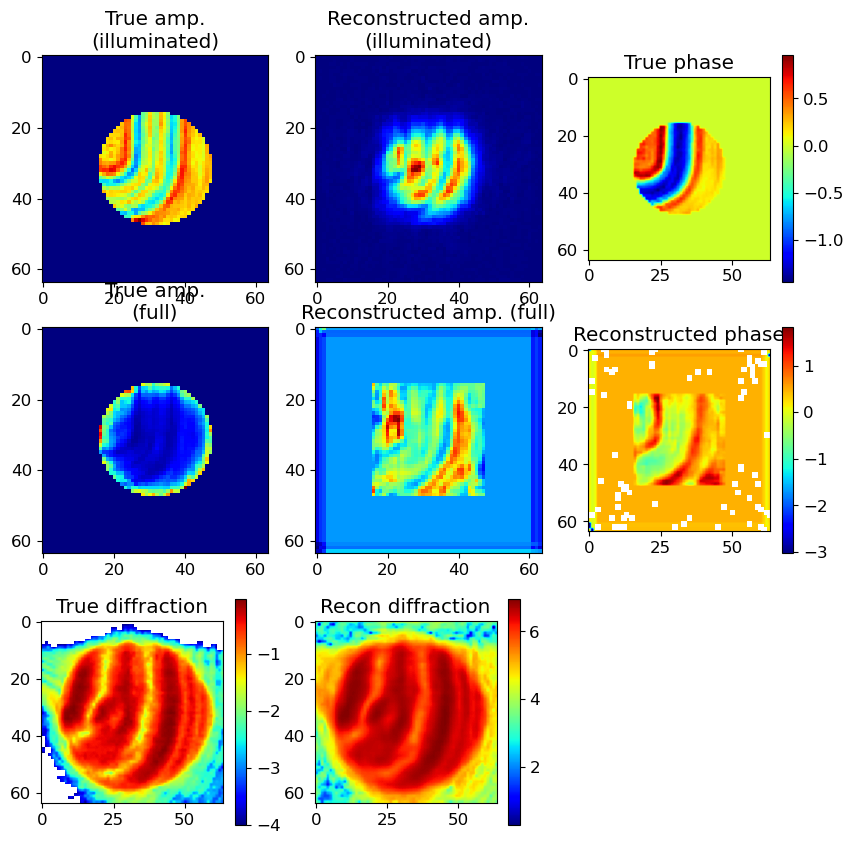

In [12]:
i = 200
from ptycho import evaluation
evaluation.summarize(i, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test,
                     np.absolute(p.get('probe')[:, :, 0]), 0,
                    crop = False);